In [ ]:
# Paquetes

import numpy as np
import sympy as spp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
from ipywidgets import interact, widgets
from IPython.display import display, Markdown
spp.init_printing(use_latex='mathjax')
plt.rcParams['mathtext.fontset'] = 'stix'

# ***Turbina Pelton***

### *Particular*

In [ ]:
def prop(alt_neta,Dt,di,i):
  di=di/100; d = np.sqrt(i*(di**2))
  C1 = 0.97*np.sqrt(2*9.806*alt_neta); u = C1*0.75
  Q = C1*(np.pi*(di**2)/4); Qi = Q/i; W1 = C1-u; W2 = 0.8*W1 
  B2 = 12; C2u = u-(W2*np.cos(B2*np.pi/180)); alt_util = u*(C1-C2u)/9.806
  nH = alt_util/alt_neta; nt = nH*0.97*100
  P = 1000*Q*u*(W1*np.cos(0*np.pi/180)+W2*np.cos(B2*np.pi/180))
  n = 60*u/(np.pi*Dt); D = 30*C1/(np.pi*n); print('\n')

  print('Pérdidas hidráulicas: ',round(alt_neta-alt_util,2), 'm')
  print('Velocidad angular: ', round(n,2), 'rpm')
  print('Caudal: ', round(Q*1000,2), 'L/s')
  print('Potencia: ', round(P,2), 'W')
  print('Rendimiento total: ', round(nt,2), '%')

interact(prop, alt_neta = widgets.IntText(description="Altura neta (m): ",value='1',step=10),
  Dt = widgets.FloatSlider(description="Diámetro de la turbina (m): ",min=0.1,max=1,step=0.01),
  di = widgets.FloatSlider(description="Diámetro del chorro (cm): ",min=0,max=10,step=0.5),
  i = widgets.IntText(description="Inyectores: ",value='1',step=1))
plt.show()

interactive(children=(IntText(value=1, description='Altura neta (m): ', step=10), FloatSlider(value=0.1, descr…

In [ ]:
#alt_neta=15; Dt=0.25; di=5.5; i=1
#alt_neta=28; Dt=0.18; di=2.12; i=4
#alt_neta=50; Dt=0.30; di=1.3; i=1
alt_neta=120; Q=700; i=3

Q=Q/1000; C1 = 0.97*np.sqrt(2*9.807*alt_neta)
u = C1*0.5; W1 = C1-u; W2 = 0.8*W1
B2 = 12;  C2u = u-(W2*np.cos(B2*np.pi/180))
P = -1000*Q*u*(C2u-C1); a1 = np.arccos(2*P/(2*u*Q*1000*C1))
di = np.sqrt(4*Q/(C1*np.pi)); alt_util = u*(C1*np.cos(a1*np.pi/180)-C2u)/9.807
nH = alt_util/alt_neta; nt = nH*0.97*100
Dt = np.sqrt((4*Q/(np.pi*(1-(0.51)**2)*C1))/np.sin(a1*np.pi/180))
w = u/(Dt/2); n = w*30/np.pi; print('\n')
print('Pérdidas hidráulicas: ',round(alt_neta-alt_util,2), 'm')
print('Diámetro del inyector: ', round(di*100,2), 'cm')
print('Diámetro de la turbina: ', round(Dt*100,2), 'cm')
print('Velocidad angular: ', round(n,2), 'rpm')
print('Potencia: ', round(P/1000,2), 'kW')
print('Rendimiento total: ', round(nt,2), '%')



Pérdidas hidráulicas:  19.37 m
Diámetro del inyector:  13.76 cm
Diámetro de la turbina:  176.52 cm
Velocidad angular:  254.58 rpm
Potencia:  690.82 kW
Rendimiento total:  81.34 %


## *General*

### Cálculos

In [ ]:
print('Datos:'); n=int(input())
alt_neta = np.linspace(1*(10**-6),1700,n)
#C1 = 0.97*np.sqrt(2*9.806*alt_neta); u = C1*0.5
C1 = np.linspace(1*(10**-6),120,n); u = C1*0.5
W1 = C1-u; W2 = 0.7*W1; B2 = np.linspace(5,20,n)
C2u = u-(W2*np.cos(B2*np.pi/180)); alt_util = u*(C1-C2u)/9.806
nH = alt_util/alt_neta; nt = nH*0.97*100
d = np.linspace(0.05,2,n); Q = C1*(np.pi*(d**2)/4)
F = 1000*Q*(W1*np.cos(0*np.pi/180)+W2*np.cos(B2*np.pi/180))
P = (F*u)/1000000

Datos:
8


### ***Rendimiento total y Altura neta***

#### Ajuste de datos

In [ ]:
# Ajuste potencial
print('Último dato a tomar: '); dat = int(input()); alt_neta0 = alt_neta[:dat]
model = LinearRegression()
Y = np.log(nt[:dat]); X = np.log(alt_neta0.reshape(-1,1)); model.fit(X,Y)
r2 = model.score(X,Y); b = model.intercept_; m = model.coef_[0]
r2 = round(r2,5); b = round(b,4); m = round(m,4); a = round(np.exp(b),4)
w1 = a*(alt_neta0.reshape(-1,1)**m)

# Ajustes de cuadrático
reg_poly = PolynomialFeatures(degree=2)
alt_neta_ajust = reg_poly.fit_transform(alt_neta.reshape(-1,1))
rp = linear_model.LinearRegression(); rp.fit(alt_neta_ajust,nt)
nt_ajust = rp.predict(alt_neta_ajust)

# Ajustes de los datos - Rendimiento(%) vs Altura neta(m)
fig, axes = plt.subplots(2,2, figsize=(13,9))
axes[0,0].plot(alt_neta,nt,'r*',alpha=0.65,ms=12)
axes[0,0].set_xlabel('Altura neta (m)'); axes[0,0].set_ylabel('Rendimiento total (%)')
axes[0,0].set_title('Datos'); axes[0,0].grid()
axes[0,1].plot(alt_neta0,w1,'c',lw=3)
axes[0,1].plot(alt_neta0,nt[:dat],'r*',alpha=0.7,ms=9.5)
axes[0,1].set_xlabel('Altura neta (m)'); axes[0,1].set_ylabel('Rendimiento total (%)')
axes[0,1].set_title('Ajuste potencial'); axes[0,1].grid()
axes[1,0].plot(alt_neta,nt,'r*',alpha=0.7,ms=9.5)
axes[1,0].plot(alt_neta, nt_ajust,'c',lw=3)
axes[1,0].set_xlabel('Altura neta (m)'); axes[1,0].set_ylabel('Rendimiento total (%)')
axes[1,0].set_title('Ajuste cuadrático'); axes[1,0].grid()
alt_neta0 = np.linspace(1500,2000,n); w2 = -1/(alt_neta0-1485)+nt[-1]
axes[1,1].plot(alt_neta0,w2,'c',lw=3.5)
axes[1,1].plot(alt_neta[-1],nt[-1],'r*',alpha=0.75,ms=12)
axes[1,1].set_xlim(1400,2000); #axes[1,0].set_ylim(39.32,39.349); axes[1,0].set_xlim(1400,2000)
axes[1,1].set_xlabel('Altura neta (m)'); axes[1,1].set_ylabel('Rendimiento total (%)')
axes[1,1].set_title('Ajuste asintótico'); axes[1,1].grid()
plt.subplots_adjust(hspace = 0.3, wspace = 0.2); plt.show()

print('La ecuación del ajuste potencial es: \n', 'nt(H) =',a, 'H^',m)
print('El coeficiente de correlación es:', r2); print('\n')
print('La ecuación del ajuste cuadrático es: \n', 'nt(H) =',round(rp.coef_[2],6), 'H^2 +',round(rp.coef_[1],4),'H +','(',round(rp.intercept_,4),')')
print('El coeficiente de correlación es:', round(rp.score(alt_neta_ajust,nt),4))

#### Función a trozos

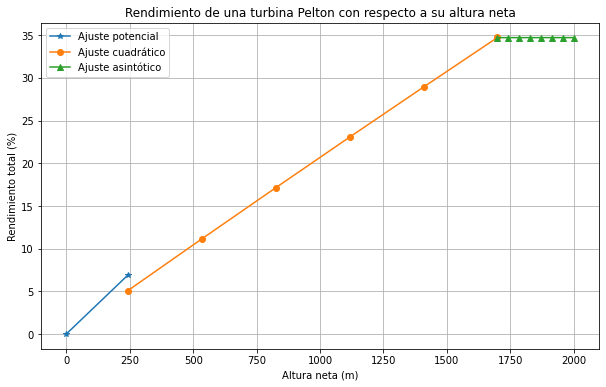

Rendimiento total(%) a 242.9 m de Altura neta:  ( 5.082 , 6.903 )
Diferencia:  1.82 %
Rendimiento total(%) a 1700.0 m de Altura neta:  ( 34.741 , 34.722 )
Diferencia:  0.02 %


In [ ]:
potencial = lambda x: a*(x**m)
cuadratica = lambda x: rp.coef_[2]*x**2 + rp.coef_[1]*x + rp.intercept_
asintotica = lambda x: -1/(x-1485)+nt[-1]
dom1 = np.linspace(alt_neta[0],alt_neta[1],2); dom2 = np.linspace(alt_neta[1],alt_neta[-1],len(alt_neta[1:-1])); dom3 = np.linspace(alt_neta[-1],2000,n)
plt.figure(figsize=(10,6))
plt.plot(dom1,potencial(dom1),'-*',label='Ajuste potencial') 
plt.plot(dom2,cuadratica(dom2),'-o',label='Ajuste cuadrático')
plt.plot(dom3,asintotica(dom3),'-^',label='Ajuste asintótico')
plt.xlabel('Altura neta (m)'); plt.ylabel('Rendimiento total (%)')
plt.title('Rendimiento de una turbina Pelton con respecto a su altura neta')
plt.legend(); plt.grid(); plt.show()
print('Rendimiento total(%) a',round(alt_neta[1],1),'m de Altura neta: ','(',round(cuadratica(alt_neta[1]),3),',',round(potencial(alt_neta[1]),3),')')
print('Diferencia: ', abs(round(potencial(alt_neta[1])-cuadratica(alt_neta[1]),2)),'%')
print('Rendimiento total(%) a',round(alt_neta[-1],1),'m de Altura neta: ','(',round(cuadratica(alt_neta[-1]),3),',',round(asintotica(alt_neta[-1]),3),')')
print('Diferencia: ', abs(round(asintotica(alt_neta[-1])-cuadratica(alt_neta[-1]),2)),'%')

#### Derivada

In [ ]:
# Derivada - Función a trozos
potencial = lambda x: m*a*(x**(m-1))
cuadratica = lambda x: 2*rp.coef_[2]*x + rp.coef_[1]
asintotica = lambda x: 1/((x-1485)**2)

dom1 = np.linspace(alt_neta[0],alt_neta[1],2); dom2 = np.linspace(alt_neta[1],alt_neta[-1],len(alt_neta[1:-1])); dom3 = np.linspace(alt_neta[-1],2000,n)
plt.figure(figsize=(10,6))
plt.plot(dom1,potencial(dom1),'-*',label='Ajuste potencial') 
plt.plot(dom2,cuadratica(dom2),'-o',label='Ajuste cuadrático')
plt.plot(dom3,asintotica(dom3),'-^',label='Ajuste asintótico')
plt.xlabel('Altura neta (m)'); plt.ylabel('Rendimiento total (%)')
plt.title('Rendimiento de una turbina Pelton con respecto a su altura neta')
plt.legend(); plt.grid(); plt.show()
print('Rendimiento total(%) a',round(alt_neta[1],1),'m de Altura neta: ','(',round(cuadratica(alt_neta[1]),3),',',round(potencial(alt_neta[1]),3),')')
print('Diferencia: ', abs(round(potencial(alt_neta[1])-cuadratica(alt_neta[1]),2)),'%')
print('Rendimiento total(%) a',round(alt_neta[-1],1),'m de Altura neta: ','(',round(cuadratica(alt_neta[-1]),3),',',round(asintotica(alt_neta[-1]),3),')')
print('Diferencia: ', abs(round(asintotica(alt_neta[-1])-cuadratica(alt_neta[-1]),2)),'%')

NameError: ignored

### ***Potencia y Altura neta***

#### Ajuste de datos


Último dato a tomar: 
8


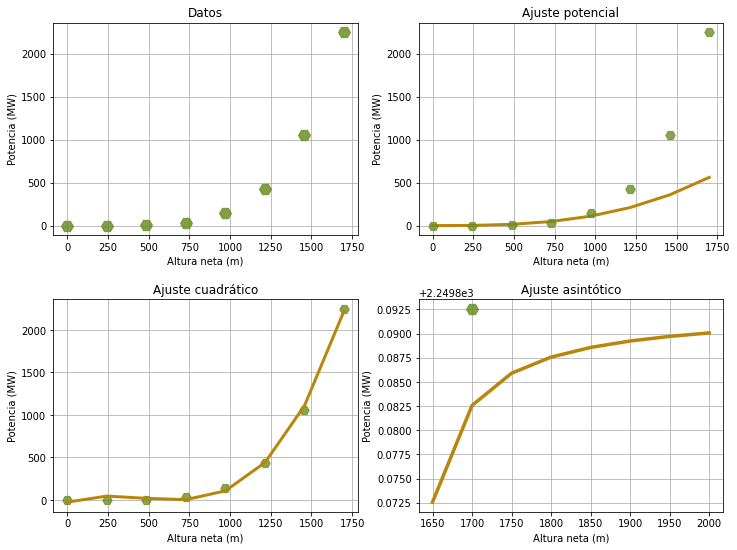

La ecuación del ajuste potencial es: 
 P(H) = 2.087e-07 H^ 2.9189
El coeficiente de correlación es: 0.99667


La ecuación del ajuste cuadrático es: 
 P(H) = 1e-06 H^3 + -0.0017 H^2 + 0.6431 H + ( -25.4256 )
El coeficiente de correlación es: 0.998


In [ ]:
# Ajuste potencial
print('Último dato a tomar: '); dat = int(input()); alt_neta0 = alt_neta[:dat]
model = LinearRegression()
Y1 = np.log(P[:dat]); X1 = np.log(alt_neta0.reshape(-1,1)); model.fit(X1,Y1)
r2_ = model.score(X1,Y1); b1 = model.intercept_; m1 = model.coef_[0]
r2_ = round(r2_,5); b1 = round(b1,4); m1 = round(m1,4); a1 = round(np.exp(b1),10)
w2 = a1*(alt_neta0.reshape(-1,1)**m1)

# Ajustes de cuadrático
reg_poly = PolynomialFeatures(degree=3)
alt_neta_ajust = reg_poly.fit_transform(alt_neta.reshape(-1,1))
rp = linear_model.LinearRegression(); rp.fit(alt_neta_ajust,P)
P_ajust = rp.predict(alt_neta_ajust)

# Ajustes de los datos - Potencia(MW) vs Altura neta(m)
fig, axes = plt.subplots(2,2, figsize=(12,9))
axes[0,0].plot(alt_neta,P,'H',c='olivedrab',alpha=0.85,ms=12)
axes[0,0].set_xlabel('Altura neta (m)'); axes[0,0].set_ylabel('Potencia (MW)')
axes[0,0].set_title('Datos'); axes[0,0].grid()
axes[0,1].plot(alt_neta[:dat],w2,'darkgoldenrod',lw=3)
axes[0,1].plot(alt_neta[:dat],P[:dat],'H',c='olivedrab',alpha=0.8,ms=9.5)
axes[0,1].set_xlabel('Altura neta (m)'); axes[0,1].set_ylabel('Potencia (MW)')
axes[0,1].set_title('Ajuste potencial'); axes[0,1].grid()
axes[1,0].plot(alt_neta,P,'H',c='olivedrab',alpha=0.8,ms=9.5)
axes[1,0].plot(alt_neta, P_ajust,'darkgoldenrod',lw=3)
axes[1,0].set_xlabel('Altura neta (m)'); axes[1,0].set_ylabel('Potencia (MW)')
axes[1,0].set_title('Ajuste cuadrático'); axes[1,0].grid()
alt_neta1 = np.linspace(1650,2000,n); w2 = -1/(alt_neta1-1600)+P[-1]
axes[1,1].plot(alt_neta1,w2,'darkgoldenrod',lw=3.5)
axes[1,1].plot(alt_neta[-1],P[-1],'H',c='olivedrab',alpha=0.85,ms=12)
axes[1,1].set_xlabel('Altura neta (m)'); axes[1,1].set_ylabel('Potencia (MW)')
axes[1,1].set_title('Ajuste asintótico'); axes[1,1].grid()
plt.subplots_adjust(hspace = 0.3, wspace = 0.2); plt.show()

print('La ecuación del ajuste potencial es: \n', 'P(H) =',a1, 'H^',m1)
print('El coeficiente de correlación es:', r2_); print('\n')
print('La ecuación del ajuste cuadrático es: \n', 'P(H) =',round(rp.coef_[3],6), 'H^3 +',round(rp.coef_[2],4),'H^2 +',round(rp.coef_[1],4),'H +','(',round(rp.intercept_,4),')')
print('El coeficiente de correlación es:', round(rp.score(alt_neta_ajust,P),4))

#### Función a trozos

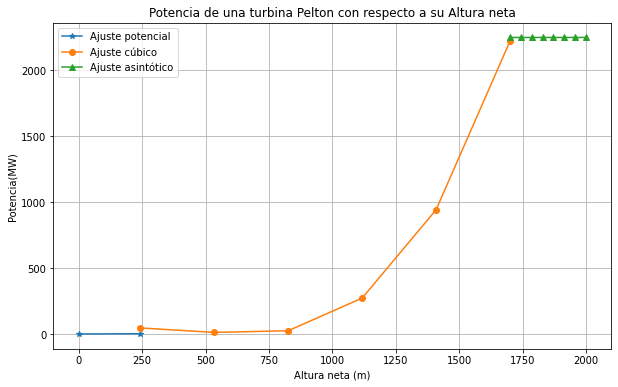

Potencia(MW) a 242.9 m de Altura neta:  ( 45.723 , 1.915 )
Diferencia:  43.81 MW
Potencia(MW) a 1700.0 m de Altura neta:  ( 2222.144 , 2249.883 )
Diferencia:  27.74 MW


In [ ]:
# Función a trozos
potencial = lambda x: a1*(x**m1)
cuadratica = lambda x: rp.coef_[3]*x**3 + rp.coef_[2]*x**2 + rp.coef_[1]*x + rp.intercept_
asintotica = lambda x: -1/(x-1600)+P[-1]
dom1 = np.linspace(alt_neta[0],alt_neta[1],2); dom2 = np.linspace(alt_neta[1],alt_neta[-1],len(alt_neta[1:-1])); dom3 = np.linspace(alt_neta[-1],2000,n)
plt.figure(figsize=(10,6))
plt.plot(dom1,potencial(dom1),'-*',label='Ajuste potencial') 
plt.plot(dom2,cuadratica(dom2),'-o',label='Ajuste cúbico')
plt.plot(dom3,asintotica(dom3),'-^',label='Ajuste asintótico')
plt.xlabel('Altura neta (m)'); plt.ylabel('Potencia(MW)')
plt.title('Potencia de una turbina Pelton con respecto a su Altura neta')
plt.legend(); plt.grid(); plt.show()
print('Potencia(MW) a',round(alt_neta[1],1),'m de Altura neta: ','(',round(cuadratica(alt_neta[1]),3),',',round(potencial(alt_neta[1]),3),')')
print('Diferencia: ', abs(round(potencial(alt_neta[1])-cuadratica(alt_neta[1]),2)),'MW')
print('Potencia(MW) a',round(alt_neta[-1],1),'m de Altura neta: ','(',round(cuadratica(alt_neta[-1]),3),',',round(asintotica(alt_neta[-1]),3),')')
print('Diferencia: ', abs(round(asintotica(alt_neta[-1])-cuadratica(alt_neta[-1]),2)),'MW')

#### Derivada

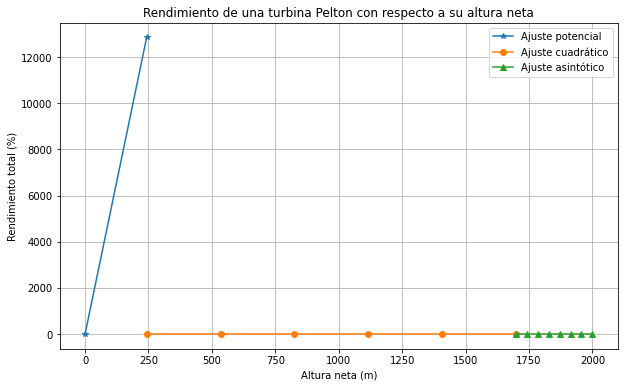

Rendimiento total(%) a 242.9 m de Altura neta:  ( 0.021 , 12857.827 )
Diferencia:  12857.81 %
Rendimiento total(%) a 1700.0 m de Altura neta:  ( 0.02 , 0.0 )
Diferencia:  0.02 %


In [ ]:
# Derivada - Función a trozos
potencial = lambda x: m1*a*(x**(m1-1))
cuadratica = lambda x: 2*p[0]*x + p[1]
asintotica = lambda x: 1/((x-1485)**2)

dom1 = np.linspace(alt_neta[0],alt_neta[1],2); dom2 = np.linspace(alt_neta[1],alt_neta[-1],len(alt_neta[1:-1])); dom3 = np.linspace(alt_neta[-1],2000,n)
plt.figure(figsize=(10,6))
plt.plot(dom1,potencial(dom1),'-*',label='Ajuste potencial') 
plt.plot(dom2,cuadratica(dom2),'-o',label='Ajuste cuadrático')
plt.plot(dom3,asintotica(dom3),'-^',label='Ajuste asintótico')
plt.xlabel('Altura neta (m)'); plt.ylabel('Rendimiento total (%)')
plt.title('Rendimiento de una turbina Pelton con respecto a su altura neta')
plt.legend(); plt.grid(); plt.show()
print('Rendimiento total(%) a',round(alt_neta[1],1),'m de Altura neta: ','(',round(cuadratica(alt_neta[1]),3),',',round(potencial(alt_neta[1]),3),')')
print('Diferencia: ', abs(round(potencial(alt_neta[1])-cuadratica(alt_neta[1]),2)),'%')
print('Rendimiento total(%) a',round(alt_neta[-1],1),'m de Altura neta: ','(',round(cuadratica(alt_neta[-1]),3),',',round(asintotica(alt_neta[-1]),3),')')
print('Diferencia: ', abs(round(asintotica(alt_neta[-1])-cuadratica(alt_neta[-1]),2)),'%')

### ***Diámetro del chorro a la entrada del alabe y Caudal***

#### Ajuste de datos

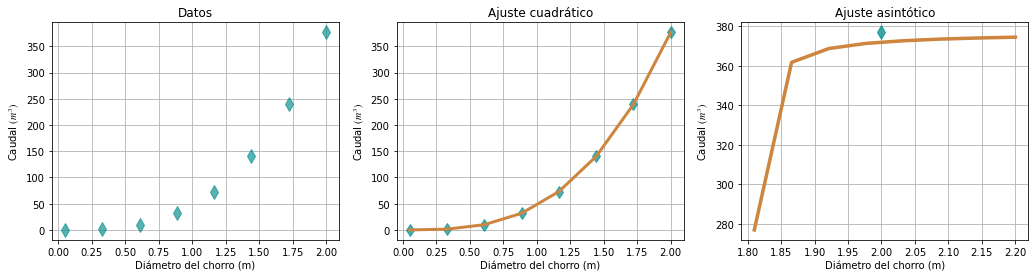


 La ecuación del ajuste cuadrático es: 
 Q(H) = 48.332194 d^3 + -2.4166 d^2 + -0.0 d + ( -0.0 )
El coeficiente de correlación es: 1.0


In [ ]:
# Ajustes de cuadrático
reg_poly = PolynomialFeatures(degree=3)
d_ajust = reg_poly.fit_transform(d.reshape(-1,1))
rp = linear_model.LinearRegression(); rp.fit(d_ajust,Q)
Q_ajust = rp.predict(d_ajust)

# Ajustes de los datos - Potencia(MW) vs Altura neta(m)
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(17.5,4))
axes[0].plot(d,Q,'d',c='darkcyan',alpha=0.65,ms=10)
axes[0].set_xlabel('Diámetro del chorro (m)'); axes[0].set_ylabel(r'Caudal $(m^3)$')
axes[0].set_title('Datos'); axes[0].grid()
axes[1].plot(d,Q,'d',c='darkcyan',alpha=0.7,ms=9)
axes[1].plot(d, Q_ajust,'peru',lw=3,ms=12)
axes[1].set_xlabel('Diámetro del chorro (m)'); axes[1].set_ylabel(r'Caudal $(m^3)$')
axes[1].set_title('Ajuste cuadrático'); axes[1].grid()
d1 = np.linspace(1.81,2.2,n); w2 = -1/(d1-1.8)+Q[-1]
axes[2].plot(d1,w2,'peru',lw=3.5)
axes[2].plot(d[-1],Q[-1],'d',c='darkcyan',alpha=0.75,ms=10)
axes[2].set_xlabel('Diámetro del chorro (m)'); axes[2].set_ylabel(r'Caudal $(m^3)$')
axes[2].set_title('Ajuste asintótico'); axes[2].grid(); plt.show()

print('\n','La ecuación del ajuste cuadrático es: \n', 'Q(H) =',round(rp.coef_[3],6), 'd^3 +',round(rp.coef_[2],4),'d^2 +',round(rp.coef_[1],7),'d +','(',round(rp.intercept_,10),')')
print('El coeficiente de correlación es:', round(rp.score(d_ajust,Q),4))

#### Función a trozos

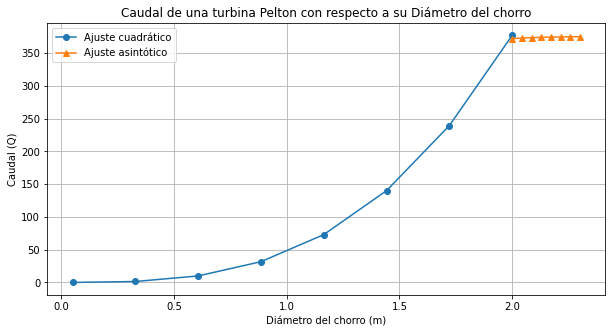

Caudal con 2.0 m de diámetro:  ( 376.991 , 371.991 )
Diferencia:  5.0 m^3


In [ ]:
# Función a trozos
cuadratica = lambda x: rp.coef_[3]*x**3 + rp.coef_[2]*x**2 + rp.coef_[1]*x + rp.intercept_
asintotica = lambda x: -1/(x-1.8)+Q[-1]
dom2 = np.linspace(d[0],d[-1],len(alt_neta)); dom3 = np.linspace(d[-1],2.3,n)
plt.figure(figsize=(10,5))
plt.plot(dom2,cuadratica(dom2),'-o',label='Ajuste cuadrático')
plt.plot(dom3,asintotica(dom3),'-^',label='Ajuste asintótico')
plt.xlabel('Diámetro del chorro (m)'); plt.ylabel('Caudal (Q)')
plt.title('Caudal de una turbina Pelton con respecto a su Diámetro del chorro')
plt.legend(); plt.grid(); plt.show()

print('Caudal con',d[-1],'m de diámetro: ','(',round(cuadratica(d[-1]),3),',',round(asintotica(d[-1]),3),')')
print('Diferencia: ', abs(round(asintotica(d[-1])-cuadratica(d[-1]),2)),'m^3')

#### Derivada

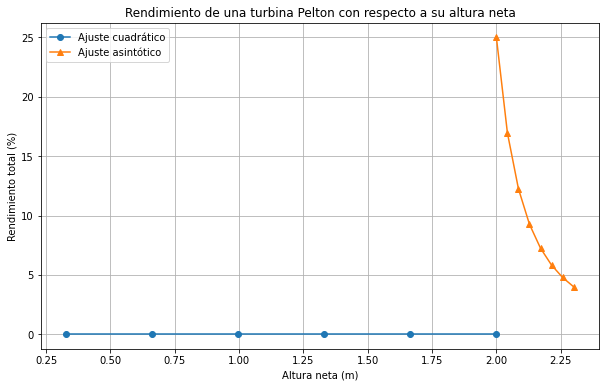

Rendimiento total(%) a 1700.0 m de Altura neta:  ( 0.02 , 0.0 )
Diferencia:  0.02 %


In [ ]:
# Derivada - Función a trozos
cuadratica = lambda x: 2*p[0]*x + p[1]
asintotica = lambda x: 1/((x-1.8)**2)

dom2 = np.linspace(d[1],d[-1],len(alt_neta[1:-1])); dom3 = np.linspace(d[-1],2.3,n)
plt.figure(figsize=(10,6))
plt.plot(dom2,cuadratica(dom2),'-o',label='Ajuste cuadrático')
plt.plot(dom3,asintotica(dom3),'-^',label='Ajuste asintótico')
plt.xlabel('Altura neta (m)'); plt.ylabel('Rendimiento total (%)')
plt.title('Rendimiento de una turbina Pelton con respecto a su altura neta')
plt.legend(); plt.grid(); plt.show()

print('Rendimiento total(%) a',round(alt_neta[-1],1),'m de Altura neta: ','(',round(cuadratica(alt_neta[-1]),3),',',round(asintotica(alt_neta[-1]),3),')')
print('Diferencia: ', abs(round(asintotica(alt_neta[-1])-cuadratica(alt_neta[-1]),2)),'%')

# ***Turbina Francis***

## *Particular*

In [ ]:
def prop(alt_neta,Dt,di,i):
  di=di/100; d = np.sqrt(i*(di**2))
  Dt=Dt/100; C1 = 0.97*np.sqrt(2*9.806*alt_neta); C2 = 0.7*C1
  u1 = C1*0.75; u2 = C2*0.75; n = 60*u1/(np.pi*Dt)
  Q = C1*(np.pi*(di**2)/4); Qr = (C1-u1)*(np.pi*(di**2)/4)
  W1 = C1-u1; C1u = u1-(W1*np.cos(0*np.pi/180))
  'Ve = 4*Q/(np.pi*(Dt**2))'; B2 = np.random.uniform(low=0,high=90)
  alt_util = u1*(C1u)/9.806; nH = alt_util/alt_neta; nt = nH*0.97*0.98
  F = 1000*Qr*(C1-u1)*(1-np.cos(B2*np.pi/180))
  P = 9806*Q*alt_neta*nt; print('\n')

  print('Pérdida hidráulica: ',round(alt_neta-alt_util,2), 'm')
  print('Velocidad angular: ', round(n/100,2), 'rpm')
  print('Caudal: ', round(Q*1000,2), 'L/s')
  #print('Velocidad en la tuberia: ', round(Ve,2), 'm/s')
  print('Potencia: ', round(P,2), 'W')
  print('Rendimiento total: ', round(nt*100,2), '%')

interact(prop, alt_neta = widgets.IntText(description="Altura neta (m): ",value='1',step=10),
  Dt = widgets.FloatSlider(description="Diámetro de la turbina (m): ",min=0.1,max=1,step=0.01),
  di = widgets.FloatSlider(description="Diámetro del chorro (cm): ",min=0,max=10,step=0.5),
  i = widgets.IntText(description="Inyectores: ",value='1',step=1))
plt.show()

interactive(children=(IntText(value=1, description='Altura neta (m): ', step=10), FloatSlider(value=0.1, descr…

In [ ]:
alt_neta=120; Q=700
Q=Q/1000; C1 = 0.97*np.sqrt(2*9.807*alt_neta); C2 = 0.7*C1
u1 = C1*0.5; u2 = C2*0.5; di = np.sqrt(4*Q/(C1*np.pi))
W1 = C1-u1; C1u = u1-(W1*np.cos(0*np.pi/180))
alt_util = u1*(C1)/9.806; nH = alt_util/alt_neta; nt = nH*0.97*0.98
P = 1000*Q*(u1*C1); a1 = np.arccos((2*P/(2*u1*Q*1000*C1))*np.pi/180)
Dt = np.sqrt((4*Q/(np.pi*(1-(0.1)**2)*C1))/np.sin(a1))
w = u1/(Dt/2); n = w*30/np.pi; print('\n')
print('Pérdidas hidráulicas: ',round(alt_neta-alt_util,2), 'm')
print('Diámetro del inyector: ', round(di*100,2), 'cm')
print('Diámetro de la turbina: ', round(Dt*100,2), 'cm')
print('Velocidad angular: ', round(n,2), 'rpm')
print('Potencia: ', round(P/1000,2), 'kW')
print('Rendimiento total: ', round(nt*100,2), '%')



Pérdidas hidráulicas:  7.08 m
Diámetro del inyector:  13.76 cm
Diámetro de la turbina:  13.83 cm
Velocidad angular:  3248.78 rpm
Potencia:  775.1 kW
Rendimiento total:  89.45 %


## *General*

### *Cálculos*

In [ ]:
print('Datos: '); n = 8
Dt=0.18; di=2.12; i=4
alt_neta = np.linspace(1*(10**-6),1700,n)
di=di/100; d = np.sqrt(i*(di**2))
Dt=Dt/100; C1 = np.linspace(1*(10**-6),120,n); C2 = 0.7*C1
u1 = C1*0.75; u2 = C2*0.75; w = u1/Dt; n = 30*w/np.pi
Q = C1*(np.pi*(di**2)/4); Qr = (C1-u1)*(np.pi*(di**2)/4)
u1 = w*di/2; W1 = C1-u1; C1u = C1
'Ve = 4*Q/(np.pi*(Dt**2))'; B2 = np.random.uniform(low=0,high=90)
alt_util = u1*(C1u)/9.806; nH = alt_util/alt_neta; nt = nH*0.97*0.98
F = 1000*Qr*(C1-u1)*(1-np.cos(B2*np.pi/180))
P = 1000*Q*(u1*C1u); print('\n'); n = 60*u/(np.pi*Dt); D = 30*C1/(np.pi*n)
display(P)

Datos: 




array([1.55903630e-18, 7.85427151e+03, 6.28341666e+04, 2.12065306e+05,
       5.02673311e+05, 9.81783801e+05, 1.69652240e+06, 2.69401472e+06])

### Rendimiento vs Altura neta

Último dato a tomar: 
8


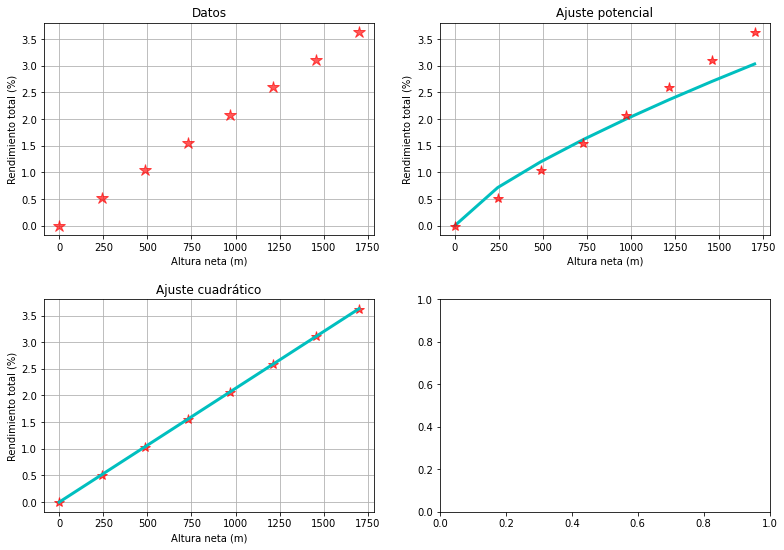

La ecuación del ajuste potencial es: 
 nt(H) = 0.012 H^ 0.7437
El coeficiente de correlación es: 0.99909


La ecuación del ajuste cuadrático es: 
 nt(H) = 0.0 H^2 + 0.0021 H + ( 0.0 )
El coeficiente de correlación es: 1.0


In [ ]:
# Ajuste potencial
print('Último dato a tomar: '); dat = int(input()); alt_neta0 = alt_neta[:dat]
model = LinearRegression()
Y = np.log(nt[:dat]); X = np.log(alt_neta0.reshape(-1,1)); model.fit(X,Y)
r2 = model.score(X,Y); b = model.intercept_; m = model.coef_[0]
r2 = round(r2,5); b = round(b,4); m = round(m,4); a = round(np.exp(b),4)
w1 = a*(alt_neta0.reshape(-1,1)**m)

# Ajustes de cuadrático
reg_poly = PolynomialFeatures(degree=2)
alt_neta_ajust = reg_poly.fit_transform(alt_neta.reshape(-1,1))
rp = linear_model.LinearRegression(); rp.fit(alt_neta_ajust,nt)
nt_ajust = rp.predict(alt_neta_ajust)

# Ajustes de los datos - Rendimiento(%) vs Altura neta(m)
fig, axes = plt.subplots(2,2, figsize=(13,9))
axes[0,0].plot(alt_neta,nt,'r*',alpha=0.65,ms=12)
axes[0,0].set_xlabel('Altura neta (m)'); axes[0,0].set_ylabel('Rendimiento total (%)')
axes[0,0].set_title('Datos'); axes[0,0].grid()
axes[0,1].plot(alt_neta0,w1,'c',lw=3)
axes[0,1].plot(alt_neta0,nt[:dat],'r*',alpha=0.7,ms=9.5)
axes[0,1].set_xlabel('Altura neta (m)'); axes[0,1].set_ylabel('Rendimiento total (%)')
axes[0,1].set_title('Ajuste potencial'); axes[0,1].grid()
axes[1,0].plot(alt_neta,nt,'r*',alpha=0.7,ms=9.5)
axes[1,0].plot(alt_neta, nt_ajust,'c',lw=3)
axes[1,0].set_xlabel('Altura neta (m)'); axes[1,0].set_ylabel('Rendimiento total (%)')
axes[1,0].set_title('Ajuste cuadrático'); axes[1,0].grid()
plt.subplots_adjust(hspace = 0.3, wspace = 0.2); plt.show()

print('La ecuación del ajuste potencial es: \n', 'nt(H) =',a, 'H^',m)
print('El coeficiente de correlación es:', r2); print('\n')
print('La ecuación del ajuste cuadrático es: \n', 'nt(H) =',round(rp.coef_[2],6), 'H^2 +',round(rp.coef_[1],4),'H +','(',round(rp.intercept_,4),')')
print('El coeficiente de correlación es:', round(rp.score(alt_neta_ajust,nt),4))

# ***Turbina Kaplan***

In [ ]:
def prop(alt_neta,Q):
  Q=Q/1000; C1 = 0.97*np.sqrt(2*9.807*alt_neta)
  Pt = Q*1000*9.807*alt_neta; Pu = Pt/(0.9*0.96*0.9)
  u = 1.575*np.sqrt(2*9.807*alt_neta); c_ = 4*Q/(np.pi*(1-(0.51)**2)*C1)
  c__ = 2*Pu/(2*u*Q*1000*C1); a1 = np.arccos(c__*np.pi/180)*180/np.pi
  De = np.sqrt(c_/(np.sin(a1))); Di = 0.51*De
  w = u/(De/2); n = 30*w/np.pi; nq = n*np.sqrt(Q)/alt_neta**(3/4)
  #ns = 3.65*np.sqrt(0.97)*nq; C = (6.94*(ns**-(0.403))*De)
  #ai = (0.38 + 5.17*(10**5)*ns)*De; aa = 1/3*(C+ai)
  C1u = C1*np.cos(a1*np.pi/180); alt_util = u*(C1u)/9.807
  nH = alt_util/alt_neta; nt = nH*0.97*0.98

  print('\n'); print('Pérdida hidráulica: ',round(alt_neta*(1-alt_util),2), 'm')
  print('Diámetro externo: ', round(De*100,2), 'cm')
  #print('Curvatura del álabe: ', round(C*100,2), 'cm')
  #print('Ancho del álabe: ', round(aa*100,2), 'cm')
  print('Velocidad angular: ', round(n,2), 'rpm')
  print('Potencia útil: ', round(Pu,2), 'W')
  print('Rendimiento total: ', round(nt*1000,2), '%')

interact(prop, alt_neta = widgets.IntText(description="Altura neta (m): ",value='1',step=10),
  Q = widgets.FloatSlider(description="Caudal (cm): ",min=0.001,max=500,step=10))
plt.show()

interactive(children=(IntText(value=1, description='Altura neta (m): ', step=10), FloatSlider(value=0.001, des…

In [ ]:
alt_neta=120; Q=700; 
Q=Q/1000; C1 = 0.97*np.sqrt(2*9.807*alt_neta)
Pt = Q*1000*9.807*alt_neta; Pu = Pt/(0.9*0.96*0.9)
u = 1.575*np.sqrt(2*9.807*alt_neta); c_ = 4*Q/(np.pi*(1-(0.51)**2)*C1)
c__ = 2*Pu/(2*u*Q*1000*C1); a1 = np.arccos(c__*np.pi/180)
De = np.sqrt(c_/(np.sin(a1))); Di = 0.51*De
w = u/(De/2); n = 30*w/np.pi; nq = n*np.sqrt(Q)/alt_neta**(3/4)
C1u = C1*np.cos(a1); alt_util = u*(C1u)/9.807
nH = alt_util/alt_neta; nt = nH*0.97*0.98

print('Pérdida hidráulica: ',round(alt_neta*(1-alt_util),2), 'm')
print('Diámetro externo: ', round(De*100,2), 'cm')
print('Velocidad angular: ', round(n,2), 'rpm')
print('Potencia útil: ', round(Pt/1000,2), 'kW')
print('Rendimiento total: ', round(nt*1000,2), '%')

Pérdida hidráulica:  -203.21 m
Diámetro externo:  16.0 cm
Velocidad angular:  9121.26 rpm
Potencia útil:  823.79 kW
Rendimiento total:  21.34 %


# ***Combinación***

In [ ]:
def t(T):
  if T == 'Pelton':
    def prop(alt_neta,Q):
      Q=Q/1000; C1 = 0.97*np.sqrt(2*9.807*alt_neta)
      u = C1*0.55; W1 = C1-u; W2 = 0.8*W1
      B2 = 12;  C2u = u-(W2*np.cos(B2*np.pi/180))
      P = -1000*Q*u*(C2u-C1); a1 = np.arccos(2*P/(2*u*Q*1000*C1))
      di = np.sqrt(4*Q/(C1*np.pi)); alt_util = u*(C1*np.cos(a1*np.pi/180)-C2u)/9.807
      nH = alt_util/alt_neta; nt = nH*0.97*100
      Dt = np.sqrt((4*Q/(np.pi*(1-(0.51)**2)*C1))/np.sin(a1*np.pi/180))
      w = u/(Dt/2); n = w*30/np.pi; print('\n')
      print('Pérdidas hidráulicas: ',round(alt_neta-alt_util,2), 'm')
      print('Diámetro del inyector: ', round(di*100,2), 'cm')
      print('Diámetro de la turbina: ', round(Dt*100,2), 'cm')
      print('Velocidad angular: ', round(n,2), 'rpm')
      print('Potencia: ', round(P,2), 'W')
      print('Rendimiento total: ', round(nt,2), '%')
    interact(prop, alt_neta = widgets.IntText(description="Altura neta (m): ",value='1',step=10),
      Q = widgets.FloatSlider(description="Caudal: ",min=1,max=30000,step=1))
    plt.show()
  
  if T == 'Francis':
    def prop(alt_neta,Q):
      Q=Q/1000; C1 = 0.97*np.sqrt(2*9.807*alt_neta); C2 = 0.7*C1
      u1 = C1*0.5; u2 = C2*0.5; di = np.sqrt(4*Q/(C1*np.pi))
      W1 = C1-u1; C1u = u1-(W1*np.cos(0*np.pi/180))
      alt_util = u1*(C1)/9.806; nH = alt_util/alt_neta; nt = nH*0.97*0.98
      P = 1000*Q*(u1*C1); a1 = np.arccos((2*P/(2*u1*Q*1000*C1))*np.pi/180)
      Dt = np.sqrt((4*Q/(np.pi*(1-(0.1)**2)*C1))/np.sin(a1))
      w = u1/(Dt/2); n = w*30/np.pi; print('\n')
      print('Pérdidas hidráulicas: ',round(alt_neta-alt_util,2), 'm')
      print('Diámetro del inyector: ', round(di*100,2), 'cm')
      print('Diámetro de la turbina: ', round(Dt*100,2), 'cm')
      print('Velocidad angular: ', round(n,2), 'rpm')
      print('Potencia: ', round(P/1000,2), 'kW')
      print('Rendimiento total: ', round(nt*100,2), '%')

    interact(prop, alt_neta = widgets.IntText(description="Altura neta (m): ",value='1',step=10),
      Q = widgets.FloatSlider(description="Caudal: ",min=1,max=30000,step=1))
    plt.show()

  if T == 'Kaplan':
    def prop(alt_neta,Q):
      Q=Q/1000; C1 = 0.97*np.sqrt(2*9.807*alt_neta)
      Pt = Q*1000*9.807*alt_neta; Pu = Pt/(0.9*0.96*0.9)
      u = 1.575*np.sqrt(2*9.807*alt_neta); c_ = 4*Q/(np.pi*(1-(0.51)**2)*C1)
      c__ = 2*Pu/(2*u*Q*1000*C1); a1 = np.arccos(c__*np.pi/180)
      De = np.sqrt(c_/(np.sin(a1))); Di = 0.51*De
      w = u/(De/2); n = 30*w/np.pi; nq = n*np.sqrt(Q)/alt_neta**(3/4)
      C1u = C1*np.cos(a1); alt_util = u*(C1u)/9.807
      nH = alt_util/alt_neta; nt = nH*0.97*0.98; print('\n')
      print('Pérdida hidráulica: ',round(alt_neta*(1-alt_util),2), 'm')
      print('Diámetro externo: ', round(De*100,2), 'cm')
      print('Velocidad angular: ', round(n,2), 'rpm')
      print('Potencia útil: ', round(Pt/1000,2), 'kW')
      print('Rendimiento total: ', round(nt*1000,2), '%')
    interact(prop, alt_neta = widgets.FloatText(description="Altura neta (m): ",value='1',step=10),
      Q = widgets.FloatSlider(description="Caudal (L/s): ",min=0.001,max=300,step=5))
    plt.show()

interact(t, T = widgets.Dropdown(options=['Pelton','Francis','Kaplan'],description='Turbina :'))
plt.show()

interactive(children=(Dropdown(description='Turbina :', options=('Pelton', 'Francis', 'Kaplan'), value='Pelton…

3.5761008613345724
17.45137220331271


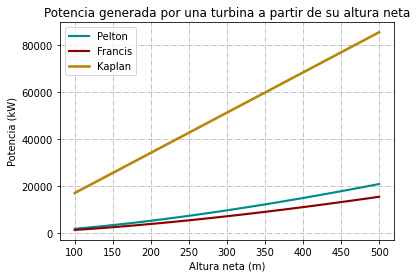

In [ ]:
#n=int(input())
alt_neta = np.linspace(100,500,100); Dt = 4; di = 0.3
C1 = 0.97*np.sqrt(2*9.806*alt_neta); u = C1*0.75
Q = C1*(np.pi*(di**2)/4); W1 = C1-u; W2 = 0.8*W1 
B2 = 12; C2u = u-(W2*np.cos(B2*np.pi/180)); alt_util = u*(C1-C2u)/9.806
nH = alt_util/alt_neta; nt = nH*0.97*100
P = 1000*Q*u*(W1*np.cos(0*np.pi/180)+W2*np.cos(B2*np.pi/180))
n = 60*u/(np.pi*Dt); D = 30*C1/(np.pi*n)

Dt = 4; di = 0.25; C1 = 0.97*np.sqrt(2*9.806*alt_neta); C2 = 0.7*C1
u1 = C1*0.75; u2 = C2*0.75; n = 60*u1/(np.pi*Dt)
Q_ = C1*(np.pi*(di**2)/4); Qr = (C1-u1)*(np.pi*(di**2)/4)
W1 = C1-u1; C1u = u1-(W1*np.cos(0*np.pi/180))
B2 = np.random.uniform(low=0,high=90)
alt_util = u1*(C1u)/9.806; nH = alt_util/alt_neta; nt = nH*0.97*0.98
F = 1000*Qr*(C1-u1)*(1-np.cos(B2*np.pi/180))
P_ = 9806*Q_*alt_neta*nt
print(np.mean(Q_))

Q = np.mean(((Q+Q_)*2)); C1 = 0.97*np.sqrt(2*9.807*alt_neta)
Pt = Q*1000*9.807*alt_neta; Pu = Pt/(0.9*0.96*0.9)
u = 1.575*np.sqrt(2*9.807*alt_neta); c_ = 4*Q/(np.pi*(1-(0.51)**2)*C1)
c__ = 2*Pu/(2*u*Q*1000*C1); a1 = np.arccos(c__*np.pi/180)*180/np.pi
De = np.sqrt(c_/(np.sin(a1))); Di = 0.51*De
w = u/(De/2); n = 30*w/np.pi; nq = n*np.sqrt(Q)/alt_neta**(3/4)
C1u = C1*np.cos(a1*np.pi/180); alt_util = u*(C1u)/9.807
nH = alt_util/alt_neta; nt = nH*0.97*0.98
print(Q)

plt.plot(alt_neta,P/1000,color='darkcyan',lw=2.15,label='Pelton')
plt.plot(alt_neta,P_/1000,color='darkred',lw=2.15,label='Francis')
plt.plot(alt_neta,Pt/1000,color='darkgoldenrod',lw=2.6,label='Kaplan')
plt.title('Potencia generada por una turbina a partir de su altura neta')
plt.xlabel(r'Altura neta (m)'); plt.ylabel('Potencia (kW)')
plt.legend(); plt.grid(ls='dashdot',lw=0.75); plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in arccos


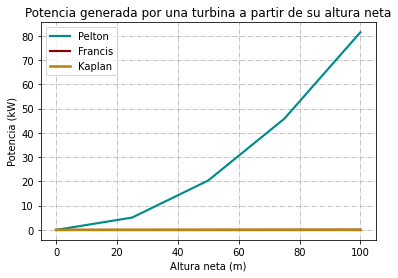

In [ ]:
#n=int(input())
alt_neta = np.linspace(1*(10**-5),100,5); Q = np.linspace(1*(10**-5),100,5)

Q=Q/1000; C1 = 0.97*np.sqrt(2*9.807*alt_neta)
u = C1*0.55; W1 = C1-u; W2 = 0.8*W1
B2 = 12;  C2u = u-(W2*np.cos(B2*np.pi/180))
P = -1000*Q*u*(C2u-C1); a1 = np.arccos(2*P/(2*u*Q*1000*C1))
di = np.sqrt(4*Q/(C1*np.pi)); alt_util = u*(C1*np.cos(a1*np.pi/180)-C2u)/9.807
nH = alt_util/alt_neta; nt = nH*0.97*100
Dt = np.sqrt((4*Q/(np.pi*(1-(0.51)**2)*C1))/np.sin(a1*np.pi/180))
w = u/(Dt/2); n = w*30/np.pi

Q=Q/1000; C1 = 0.97*np.sqrt(2*9.807*alt_neta); C2 = 0.7*C1
u1 = C1*0.5; u2 = C2*0.5; di = np.sqrt(4*Q/(C1*np.pi))
W1 = C1-u1; C1u = u1-(W1*np.cos(0*np.pi/180))
alt_util = u1*(C1)/9.806; nH = alt_util/alt_neta; nt = nH*0.97*0.98
P_ = 1000*Q*(u1*C1); a1 = np.arccos((2*P/(2*u1*Q*1000*C1))*np.pi/180)
Dt = np.sqrt((4*Q/(np.pi*(1-(0.1)**2)*C1))/np.sin(a1))
w = u1/(Dt/2); n = w*30/np.pi

Q=Q/1000; C1 = 0.97*np.sqrt(2*9.807*alt_neta)
Pt = Q*1000*9.807*alt_neta; Pu = Pt/(0.9*0.96*0.9)
u = 1.575*np.sqrt(2*9.807*alt_neta); c_ = 4*Q/(np.pi*(1-(0.51)**2)*C1)
c__ = 2*Pu/(2*u*Q*1000*C1); a1 = np.arccos(c__*np.pi/180)
De = np.sqrt(c_/(np.sin(a1))); Di = 0.51*De
w = u/(De/2); n = 30*w/np.pi; nq = n*np.sqrt(Q)/alt_neta**(3/4)
C1u = C1*np.cos(a1); alt_util = u*(C1u)/9.807

plt.plot(alt_neta,P/1000,color='darkcyan',lw=2.15,label='Pelton')
plt.plot(alt_neta,P_/1000,color='darkred',lw=2.15,label='Francis')
plt.plot(alt_neta,Pt/1000,color='darkgoldenrod',lw=2.6,label='Kaplan')
plt.title('Potencia generada por una turbina a partir de su altura neta')
plt.xlabel(r'Altura neta (m)'); plt.ylabel('Potencia (kW)')
plt.legend(); plt.grid(ls='dashdot',lw=0.75); plt.show()

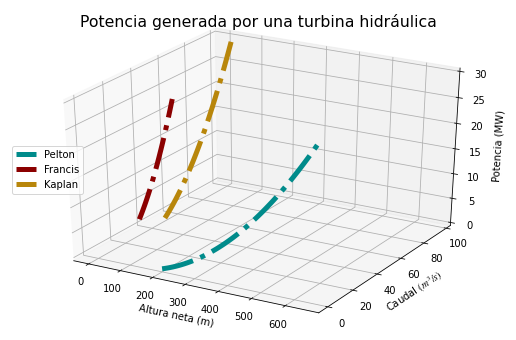

In [ ]:
#n=int(input())
fig = plt.figure(figsize=(9,6)); ax = fig.gca(projection='3d')

alt_neta = np.linspace(200,1000,200); Q = np.linspace(1*(10**-5),10000,200)
Q=Q/1000; C1 = 0.97*np.sqrt(2*9.807*alt_neta)
u = C1*0.55; W1 = C1-u; W2 = 0.8*W1
B2 = 12;  C2u = u-(W2*np.cos(B2*np.pi/180))
P = -1000*Q*u*(C2u-C1); a1 = np.arccos(2*P/(2*u*Q*1000*C1))
di = np.sqrt(4*Q/(C1*np.pi)); alt_util = u*(C1*np.cos(a1*np.pi/180)-C2u)/9.807
nH = alt_util/alt_neta; nt = nH*0.97*100
Dt = np.sqrt((4*Q/(np.pi*(1-(0.51)**2)*C1))/np.sin(a1*np.pi/180))
w = u/(Dt/2); n = w*30/np.pi
ax.plot(alt_neta[:113],Q[:113],P[P<30*(10**6)]/1000000,color='darkcyan',ls='-.',lw=5,label='Pelton')

alt_neta = np.linspace(100,500,200); Q = np.linspace(8000,80000,200)
Q=Q/1000; C1 = 0.97*np.sqrt(2*9.807*alt_neta); C2 = 0.7*C1
u1 = C1*0.5; u2 = C2*0.5; di = np.sqrt(4*Q/(C1*np.pi))
W1 = C1-u1; C1u = u1-(W1*np.cos(0*np.pi/180))
alt_util = u1*(C1)/9.806; nH = alt_util/alt_neta; nt = nH*0.97*0.98
P_ = 1000*Q*(u1*C1); a1 = np.arccos((2*P/(2*u1*Q*1000*C1))*np.pi/180)
Dt = np.sqrt((4*Q/(np.pi*(1-(0.1)**2)*C1))/np.sin(a1))
w = u1/(Dt/2); n = w*30/np.pi
ax.plot(alt_neta[:33],Q[:33],P_[P_<30*(10**6)]/1000000,color='darkred',ls='-.',lw=5,label='Francis')

alt_neta = np.linspace(1*(10**-5),100,200); Q = np.linspace(50000,200000,200)
Q=Q/1000; C1 = 0.97*np.sqrt(2*9.807*alt_neta)
Pt = Q*1000*9.807*alt_neta; Pu = Pt/(0.9*0.96*0.9)
u = 1.575*np.sqrt(2*9.807*alt_neta); c_ = 4*Q/(np.pi*(1-(0.51)**2)*C1)
c__ = 2*Pu/(2*u*Q*1000*C1); a1 = np.arccos(c__*np.pi/180)
De = np.sqrt(c_/(np.sin(a1))); Di = 0.51*De
w = u/(De/2); n = 30*w/np.pi; nq = n*np.sqrt(Q)/alt_neta**(3/4)
C1u = C1*np.cos(a1); alt_util = u*(C1u)/9.807
ax.plot(alt_neta[:63],Q[:63],Pt[Pt<30*(10**6)]/1000000,color='darkgoldenrod',ls='-.',lw=5,label='Kaplan')

ax.set_title('Potencia generada por una turbina hidráulica',size=15.8)
ax.set_xlabel('Altura neta (m)'); ax.set_ylabel(r'Caudal $(m^3/s)$')
ax.set_zlabel('Potencia (MW)'); ax.set_zlim3d(0,30)
ax.legend(loc=6); plt.show()

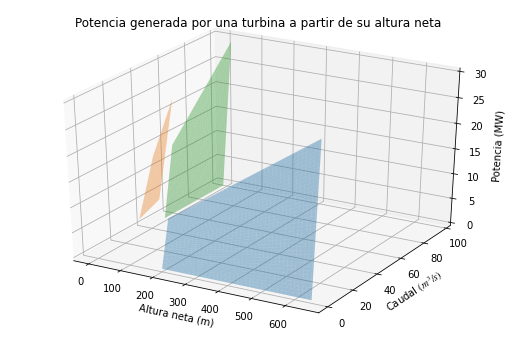

In [ ]:
#n=int(input())
fig = plt.figure(figsize=(9,6)); ax = fig.gca(projection='3d')

alt_neta = np.linspace(200,1000,200); Q = np.linspace(1*(10**-5),10000,200)
Q=Q/1000; X,Y = np.meshgrid(alt_neta[:113],Q[:113])
C1 = 0.97*np.sqrt(2*9.807*X); C11 = 0.97*np.sqrt(2*9.807*alt_neta)
u = C1*0.55; W1 = C1-u; W2 = 0.8*W1; u1 = C11*0.55; W11 = C11-u1; W21 = 0.8*W11
B2 = 12;  C2u = u-(W2*np.cos(B2*np.pi/180)); C2u1 = u1-(W21*np.cos(B2*np.pi/180))
P = -1000*Y*u*(C2u-C1); P1 = -1000*Q*u1*(C2u1-C11)
ax.plot_surface(X,Y,P/1000000,alpha=0.4)

alt_neta = np.linspace(100,500,200); Q = np.linspace(8000,80000,200)
Q=Q/1000; X,Y = np.meshgrid(alt_neta[:33],Q[:33])
C1 = 0.97*np.sqrt(2*9.807*X); C2 = 0.7*C1
u1 = C1*0.5; u2 = C2*0.5
W1 = C1-u1; C1u = u1-(W1*np.cos(0*np.pi/180))
P_ = 1000*Y*(u1*C1); 
ax.plot_surface(X,Y,P_/1000000,alpha=0.4,label='Francis')

alt_neta = np.linspace(1*(10**-5),100,200); Q = np.linspace(50000,200000,200)
Q=Q/1000; X,Y = np.meshgrid(alt_neta[:63],Q[:63])
C1 = 0.97*np.sqrt(2*9.807*X)
Pt = Y*1000*9.807*X; Pu = Pt/(0.9*0.96*0.9)
ax.plot_surface(X,Y,Pt/1000000,alpha=0.4,label='Kaplan')

ax.set_title('Potencia generada por una turbina a partir de su altura neta')
ax.set_xlabel(r'Altura neta (m)'); ax.set_ylabel(r'Caudal $(m^3/s)$')
ax.set_zlabel('Potencia (MW)'); ax.set_zlim3d(0,30); plt.show()